# Variance Reduction Part

In [1]:
import time

import torch
from tqdm import trange
from torch import nn, autograd, optim

%matplotlib notebook 
import matplotlib.pyplot as plt

from nets import *
from graphics import *

In [2]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x), u(t, 0) = gauss(0)}
# Also, it is used here to set initial or boundary conditions in other equations
def dome(x, t=0, a=.5, alpha=200, shift=0.):
    if isinstance(t, torch.Tensor):
        t = t[:, None]
    psi = torch.exp(-alpha*torch.tensor(shift**2))
    res = torch.exp(-alpha*(x-shift-a*t)**2)
    out = torch.empty_like(res).fill_(psi.item())
    out[x - a*t > 0] = res[x - a*t > 0]
    
    return out

In [3]:
# Evaluation metrics
max_error = lambda u_exact, u_approx: torch.norm(u_exact - u_approx, p=float('inf'))
avg_error = lambda u_exact, u_approx: torch.mean((u_exact - u_approx)**2)**.5 

## Advection Equation

In [4]:
class PDE2D(nn.Module):
    """
    Base class
    ----------
    Args:
    -----
    l                 length of calculation area along x axis
                      (starting from 0)
    T                 length of calculation area along t axis
                      (starting from 0)

                      Thus, (0, l) x (0, T) is the training domain
    """
    def __init__(self, l=1., T=2.):
        super().__init__()
        self.l = l
        self.T = T
    
    def sampleBatch(self, N=5120, device='cpu'):
        """
        Simple sampler
        Generates pair (t, x), from which one can build the pairs
        (t, x), (t, 0), (0, x)
        Works slightly worse than if these pairs were generated independently
        ----------------------
        N - number of points to sample in the domain (x, t)
        """
        tx = torch.rand(N, 2, device=device)
        tx[:, 0].mul_(self.T)
        tx[:, 1].mul_(self.l)

        return tx
    
    def _D(self, y, x):
        grad = autograd.grad(
            outputs=y, inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True, allow_unused=True)
        
        if len(grad) == 1:
            return grad[0]
        return grad

In [6]:
class AdvectionPDE(PDE2D):
    """
    Homogeneous Advection Equation
    -------------------------------------
    du/dt + a du/dx = 0
    u(0, x) = gauss(x)
    u(t, 0) = gauss(0)
    -------------------------------------
    Args:
    -----
    a                 wave velocity
    """
    def __init__(self, a=.5, l=1., T=2.):
        super().__init__(l, T)
        self.a = a

    def computeLoss(self, tx, net):
        t, x = torch.unbind(tx, 1)
        o = torch.zeros_like(t)
        u_t, u_x = self._D(net(t,x), (t,x))
        L = (torch.norm(u_t + self.a * u_x)
             + torch.norm(net(o, x) - dome(x, shift=.25))
             + torch.norm(net(t, o) - dome(x.new(1).fill_(0.), shift=.25)))
            
        return L

In [7]:
def train(net, pde, optimizer, loss_history, batch_size=5120):
    for _ in trange(num_batches, desc='Training'):
        optimizer.zero_grad()
     
        batch = pde.sampleBatch(batch_size, device)
        batch.requires_grad_(True)
     
        loss = pde.computeLoss(batch, net)
        loss_history.append(loss.item())
        loss.backward()
     
        optimizer.step()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)

pde = AdvectionPDE()
# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

#net = DGM(d=1, M=50, L=3).to(device)
net = DumbLinear('3l', base_width=128).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters())
loss_history = []

You have 0 gpus


In [9]:
try:
    train(net, pde, optimizer, loss_history, 128)
except KeyboardInterrupt:
    pass

Training: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [02:35<00:00, 64.14it/s]


<IPython.core.display.Javascript object>


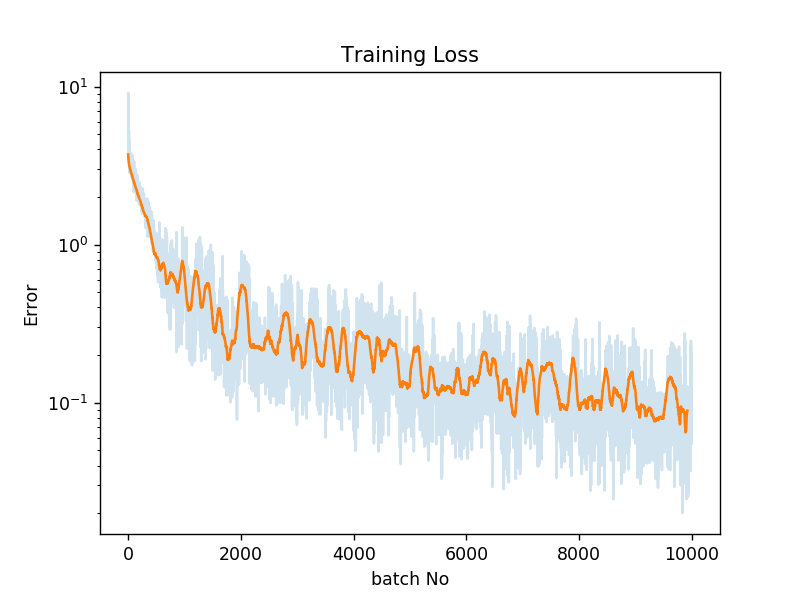

In [10]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

### Initial condition approximation

max error 0.019107818603515625
avg error 0.01031520962715149


<IPython.core.display.Javascript object>


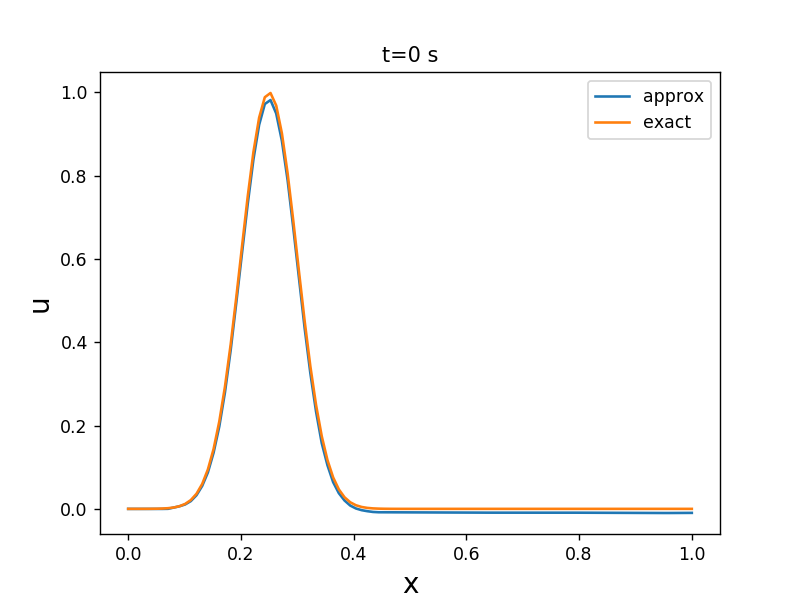

In [11]:
x = torch.linspace(0, 1, device=device)
o = torch.zeros_like(x)

y_true = dome(x, shift=.25)
y = net(o, x).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu().numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('t=0 s')
plt.legend();

### Approximation at time `t`

max error 0.02560192346572876
avg error 0.007243983913213015


<IPython.core.display.Javascript object>


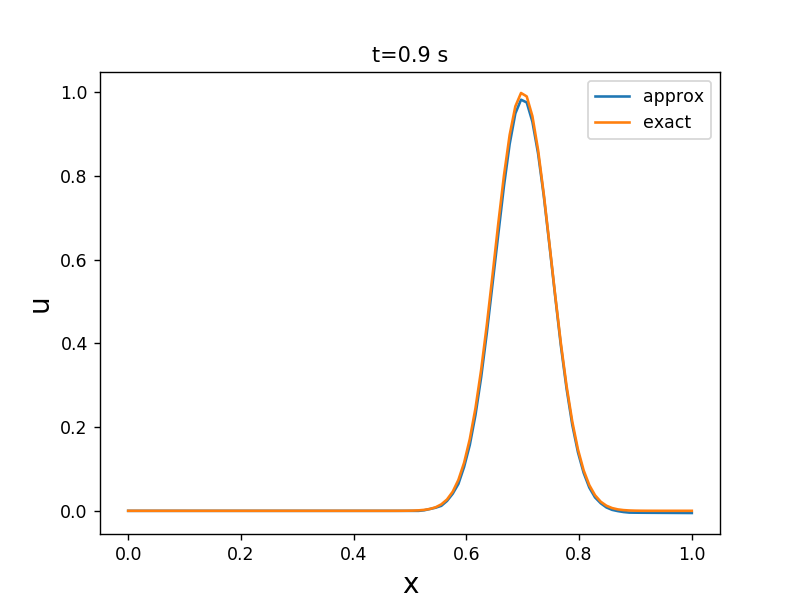

In [12]:
t_val = .9 
x = torch.linspace(0, 1, device=device)
t = torch.empty_like(x).fill_(t_val)

y_true = dome(x, t_val, shift=.25)
y = net(t, x).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.cpu().numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

### Run cell to start animating
if there is only one graph, re-run the cell

---
As expected, the approximation is fairly good on the training data, and when the model encounters test data the solutions begin to diverge

<IPython.core.display.Javascript object>


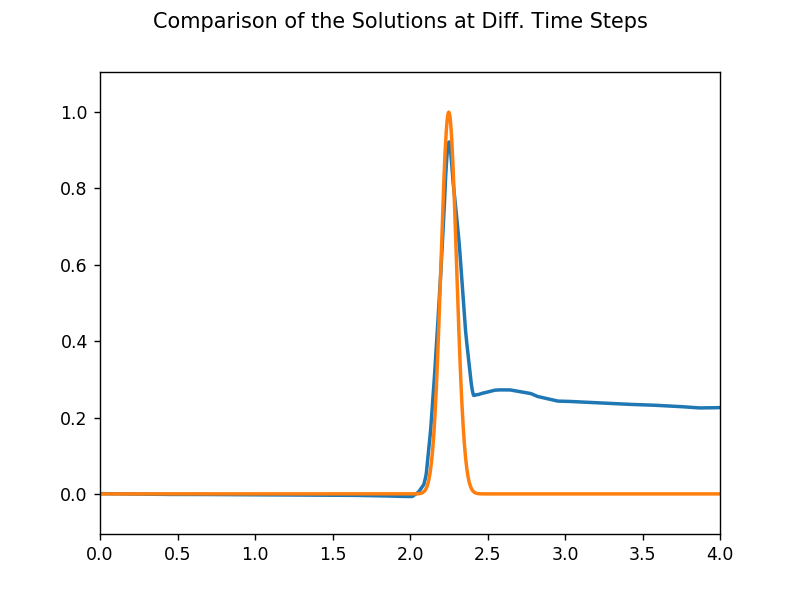

In [13]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t, shift=.25)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
y = net(t.to(device), x.to(device)).view(len(x), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

---
## Numerical Solution
finite-difference and nonstandard finite-difference methods

$$
\left\{\begin{aligned}
    &u_i^{n+1} = u_i^n + a\Delta t (u_{i-1}^n- u_i^n)\\
    &u_i^0 = \exp(-\alpha(i\Delta h - 0.25)^2)\\
    &u_0^n = 0
\end{aligned}\right.
$$

In [66]:
l = 1
T = 1
u_t0 = torch.tensor([0.])
dx = 1e-3
rdx = 1 / dx
dt = 2e-3
a = .5

x = torch.linspace(0, l, int(l/dx))
u_0x = dome(x, a=a)
u_exact = dome(x, t=T, a=a)

def one_time_step(u):
    return u + torch.cat([u_t0, -a*dt*rdx * (u[1:] - u[:-1])])

In [67]:
u1 = u_0x
for i in range(int(.5 * T / dt)):
    u2 = one_time_step(u1)
    u1 = one_time_step(u2)

<IPython.core.display.Javascript object>


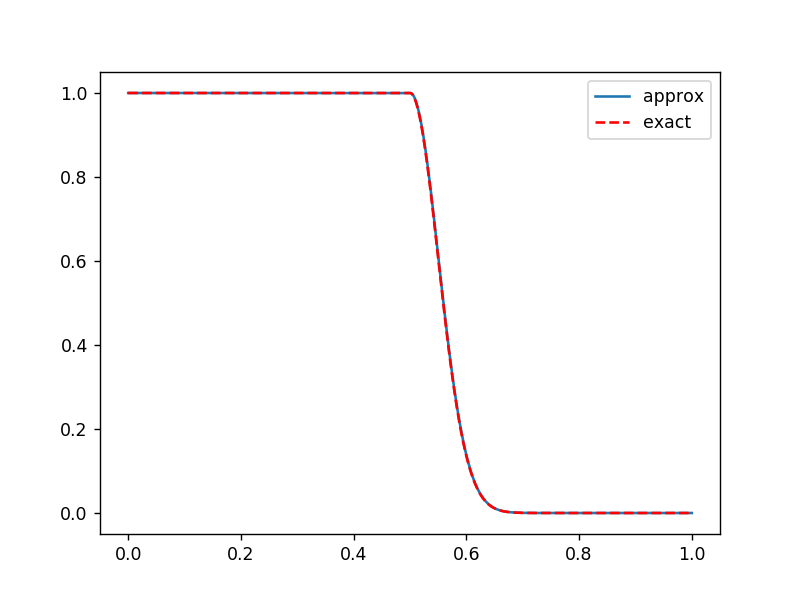

max error 0.006070733070373535
avg error 0.0014891782775521278


In [68]:
plt.figure()
print('max error', max_error(u_exact, u1).item())
print('avg error', avg_error(u_exact, u1).item())
plt.plot(x.numpy(), u1.numpy(), label='approx')
plt.plot(x.numpy(), u_exact.numpy(), '--r', label='exact')
plt.legend();

## Fisher Equation

---
* **Case 1**
$$
\left\{\begin{aligned}
    &u_t - u\,u_{xx} = u(1-u), \quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = 0, \quad x \in (0,l]\\
    &u(t, 0) = 1, \quad t \in [0,T]\\
    &u(t, L) = 0, \quad t \in [0,T]\\
    &0 \lt u(t, x) \lt 1\\
\end{aligned}\right.
$$

**Nonstandard Finite Difference Method (NSFDM)** for the problem above

$$
    \frac{u^{n+1}_m - u^n_m}{\phi(\Delta t)}
    = u^{n+1}_m \left[\frac{u^n_{m+1} - 2u^n_m + u^n_{m-1}}{\psi(\Delta x)}\right]
    + 2\bar u^n_m - u^{n+1}_m - u^{n+1}_m \bar u^n_m
$$

$$
    \bar u^n_m \equiv \frac{u^n_{m+1} + u^n_{m-1}}{2}
$$

One can check that this scheme is stable (considering that initial values of $0 < u < 1$)
if $\frac{\phi(\Delta t)}{\psi(\Delta x)} \lt \frac{1}{2}$ (without any spectral analysis).
The stability condition might be or might be not weakened, if analyzed more thoroughly

Here, the 'denominator function' (calling such both $\psi$ and $\phi$ in general) satisfies:

$$
    \varphi(h, \lambda) = h + O(h^2)
$$

$\lambda$ is some hyperparameter that might appear in PDEs (as an example of $\varphi$ you can consider $\exp(\bullet) - 1$)  
For the sake of simplicity, we can take $\quad\phi(\Delta t) = \Delta t, \qquad \psi(\Delta x) = (\Delta x)^2$  
What else is worth mentioning here is that terms $u$ and $u^2$ are discretized non-locally
($u \to 2\bar u^n_m - u^{n+1}_m$ instead of just $u^n_m$, and likewise, $u^2 \to u^{n+1}_m\bar u^n_m$)  
Local discretization in turn prevents the propagation of diffusion process (see in [the paper](https://core.ac.uk/download/pdf/82343686.pdf) how)

This scheme is explicit, so we can write
$$
    u^{n+1}_m = \frac{u^n_m + 2\phi\bar u^n_m}{1+ \phi + \frac{2\phi}{\psi}(u^n_m - \bar u^n_m)+\phi\bar u^n_m}
$$

* **Case 2**

Also, we can consider similar problem:

$$
\left\{\begin{aligned}
    &u_t - D\,u_{xx} = ru(1-u), \quad (t,x) \in [0,T]\times[0, l]\\
    &u(0, x) = \mathrm{dome}(x), \quad t \in [0,T]\\
    &u(t, 0) = 1, \quad x \in [0,l]\\
    &u(t, L) = 0, \quad x \in [0,l]\\
    &0 \lt u(t, x) \lt 1\\
\end{aligned}\right.
$$

With simple stability analysis, we have $\frac{2D\phi(\Delta t)}{\psi(\Delta x)} \lt 1$ 
and $2\frac{D}{\psi} \le r$ (again, probably it might be weakened, and better to check it,
I am not sure I didn't make a mistake in the derivation) for the following num. scheme

$$
    u^{n+1}_m = \frac{\frac{2D\phi}{\psi}(\bar u^n_m - u^n_m) + 2r\phi u^n_m}
    {1 + r\phi\cdot(1 + u^n_m)}
$$

In [69]:
l = 1.
T = 200.
r = 100.
u_t0 = dome(torch.zeros(1))
u_tl = dome(torch.ones(1))

dx = 5e-2
dt = 1e-2
D = .1  # in FisherPDE it is 'a'

C1 = D*dt/dx/dx
C2 = r*dt

# print(C1)
# print(C2)
assert C1 < .5
assert 2*C1 <= C2

x = torch.linspace(0, l, int(l/dx))
u_0x = dome(x, shift=0.)

def one_time_step(u):
    bar_u = u[2:] + u[:-2]
    out = (C1*(bar_u - u[1:-1]) + C2*u[1:-1]) / (1 + C2*(.5+u[1:-1]))
    return torch.cat([u_t0, out, u_tl])

In [70]:
u1 = u_0x
for i in range(int(.5*T/dt)):
    u2 = one_time_step(u1)
    u1 = one_time_step(u2)

<IPython.core.display.Javascript object>


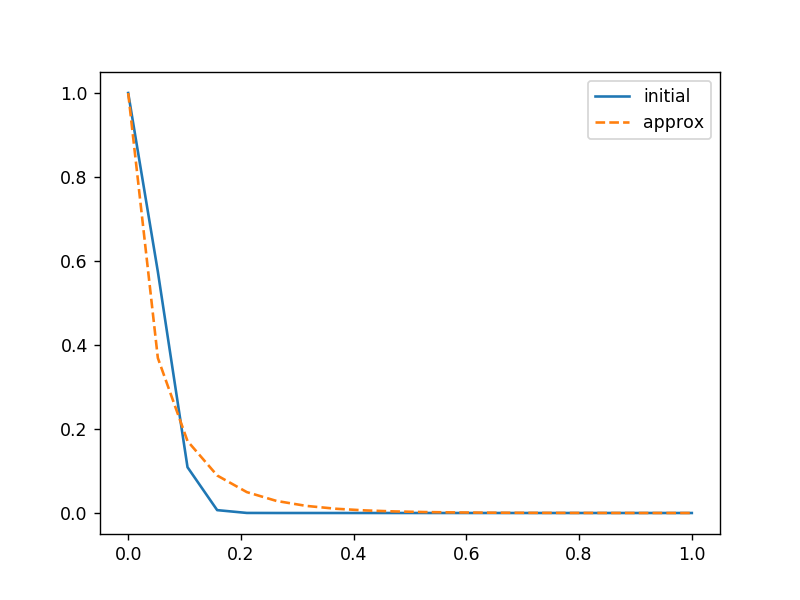

In [71]:
plt.figure()
plt.plot(x.numpy(), u_0x.numpy(), label='initial')
plt.plot(x.numpy(), u1.numpy(), '--', label='approx')
plt.legend();

## Variance reduction

In [30]:
class FisherPDE(PDE2D):
    """
    u_t - a u_xx = r u(1-u)
    u(0, x) = gauss(x)
    u(t, 0) = gauss(0)
    u(t, l) = gauss(1)
    ----------
    Args:
    -----
    a             diffusion coefficient
    r             some other coefficient
    """
    def __init__(self, a=.1, r=1., l=1., T=1.):
        super().__init__(l, T)
        self.a = a
        self.r = r
        
    def computeLoss(self, tx, net, delta=.01):
        t, x = torch.unbind(tx, 1)
        o = torch.zeros_like(t)
        l = torch.empty_like(x).fill_(self.l)
        
        D1 = delta * torch.randn_like(x)
        D2 = delta * torch.randn_like(x)
        
        y0 = net(t, x)
        u_t, u_x = self._D(y0, (t,x))
        
        u1_xx_1p = 1./delta * (self._D(net(t, x+D1), x) - u_x) * D1
        u2_xx_1p = 1./delta * (self._D(net(t, x+D2), x) - u_x) * D2
        u1_xx_1m = 1./delta * (self._D(net(t, x-D1), x) - u_x) * D1
        u2_xx_1m = 1./delta * (self._D(net(t, x-D2), x) - u_x) * D2
        
        eq_res_1p = ((u_t - self.a*u1_xx_1p - self.r*y0*(1-y0)).detach()
                     *(u_t - self.a*u2_xx_1p - self.r*y0*(1-y0)))
        eq_res_1m = ((u_t + self.a*u1_xx_1m - self.r*y0*(1-y0)).detach()
                     *(u_t + self.a*u2_xx_1m - self.r*y0*(1-y0)))
        
        # Should I take .abs() here, in the sum?
        L = (torch.sum((eq_res_1p + eq_res_1m).abs())
             + torch.norm(net(o, x) - dome(x))
             + torch.norm(net(t, o) - dome(x.new(1).fill_(0.)))
             + torch.norm(net(t, l) - dome(x.new(1).fill_(self.l))))
        
        return L
    
##################################################
#########  Without variance reduction ############
##################################################
#     def computeLoss(self, tx, net, delta=.01):
#         t, x = torch.unbind(tx, 1)
#         o = torch.zeros_like(t)
#         l = torch.empty_like(x).fill_(self.l)
        
#         D1 = delta * torch.randn_like(x)
#         D2 = delta * torch.randn_like(x)
        
#         y0 = net(t, x)
#         u_t, u_x = self._D(y0, (t,x))
        
#         u1_xx = 1./delta * (self._D(net(t, x+D1), x) - u_x) * D1
#         u2_xx = 1./delta * (self._D(net(t, x+D2), x) - u_x) * D2
        
#         eq_res= ((u_t - self.a*u1_xx- self.r*y0*(1-y0)).detach()
#                      *(u_t - self.a*u2_xx- self.r*y0*(1-y0)))
        
#         L = (torch.sum(eq_res)
#              + torch.norm(net(o, x) - dome(x))
#              + torch.norm(net(t, o) - dome(x.new(1).fill_(0.)))
#              + torch.norm(net(t, l) - dome(x.new(1).fill_(self.l))))
        
#         return L

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)

pde = FisherPDE()
# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

#net = DGM(d=1, M=50, L=3).to(device)
net = DumbLinear('3l', base_width=128).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters())
loss_history = []

You have 0 gpus


In [32]:
try:
    train(net, pde, optimizer, loss_history, 128)
except KeyboardInterrupt:
    pass

Training: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [05:52<00:00, 30.44it/s]


<IPython.core.display.Javascript object>


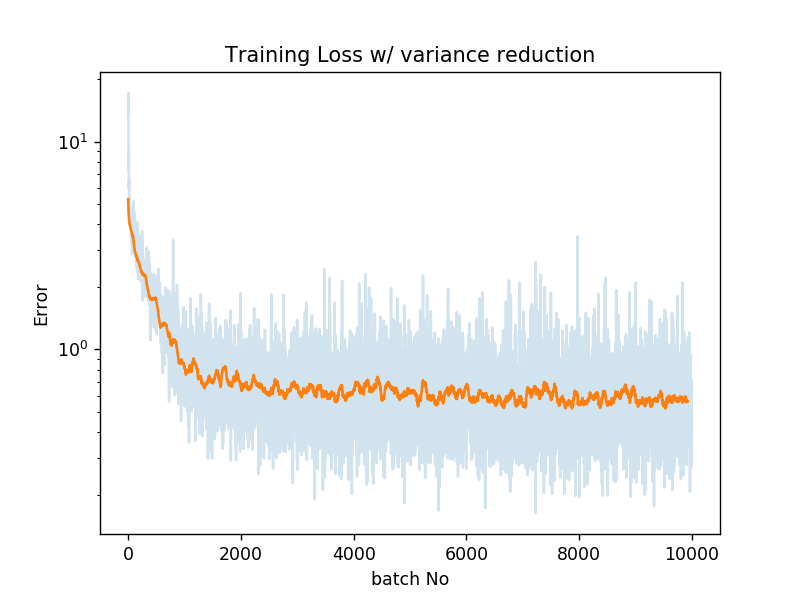

In [33]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss w/ variance reduction')
plt.ylabel('Error')
plt.xlabel('batch No');

tensor(6.7039)
tensor(7.5758)


<IPython.core.display.Javascript object>


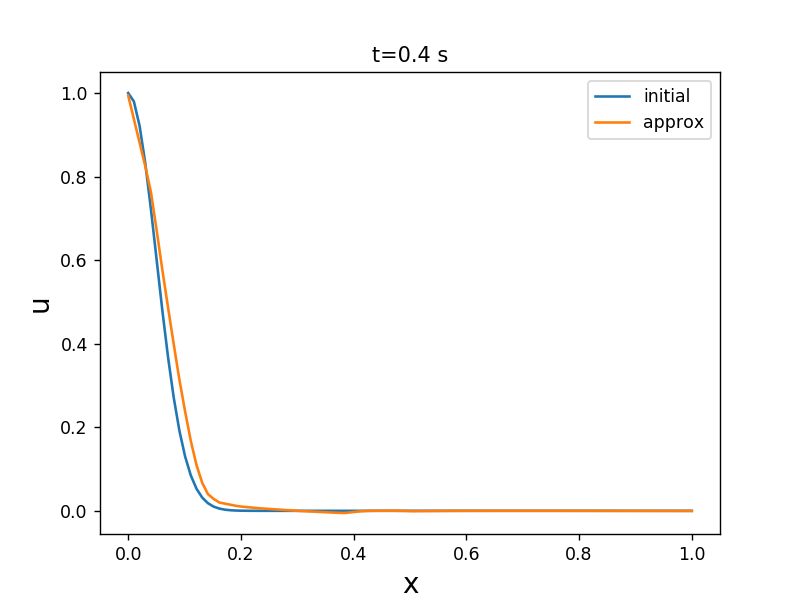

In [34]:
t_val = .4
x = torch.linspace(0, 1, device=device)
t = torch.empty_like(x).fill_(t_val)

y = net(t, x).detach().cpu()
y_initial = dome(x)
print(y_initial.sum())
print(y.sum())
# print('max error', max_error(y_true, y).item())
# print('avg error', avg_error(y_true, y).item())
x = x.cpu().numpy()

plt.figure() 
plt.plot(x, y_initial, label='initial')
plt.plot(x, y.numpy(), label='approx')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();

## Without variance reduction

In [45]:
class FisherPDE(PDE2D):
    """
    u_t - a u_xx = r u(1-u)
    u(0, x) = gauss(x)
    u(t, 0) = gauss(0)
    u(t, l) = gauss(1)
    ----------
    Args:
    -----
    a             diffusion coefficient
    r             some other coefficient
    """
    def __init__(self, a=.1, r=1., l=1., T=1.):
        super().__init__(l, T)
        self.a = a
        self.r = r
        
#     def computeLoss(self, tx, net, delta=.01):
#         t, x = torch.unbind(tx, 1)
#         o = torch.zeros_like(t)
#         l = torch.empty_like(x).fill_(self.l)
        
#         D1 = delta * torch.randn_like(x)
#         D2 = delta * torch.randn_like(x)
        
#         y0 = net(t, x)
#         u_t, u_x = self._D(y0, (t,x))
        
#         u1_xx_1p = 1./delta * (self._D(net(t, x+D1), x) - u_x) * D1
#         u2_xx_1p = 1./delta * (self._D(net(t, x+D2), x) - u_x) * D2
#         u1_xx_1m = 1./delta * (self._D(net(t, x-D1), x) - u_x) * D1
#         u2_xx_1m = 1./delta * (self._D(net(t, x-D2), x) - u_x) * D2
        
#         eq_res_1p = ((u_t - self.a*u1_xx_1p - self.r*y0*(1-y0)).detach()
#                      *(u_t - self.a*u2_xx_1p - self.r*y0*(1-y0)))
#         eq_res_1m = ((u_t + self.a*u1_xx_1m - self.r*y0*(1-y0)).detach()
#                      *(u_t + self.a*u2_xx_1m - self.r*y0*(1-y0)))
        
#         # Should I take .abs() here, in the sum?
#         L = (torch.sum(eq_res_1p + eq_res_1m)
#              + torch.norm(net(o, x) - dome(x))
#              + torch.norm(net(t, o) - dome(x.new(1).fill_(0.)))
#              + torch.norm(net(t, l) - dome(x.new(1).fill_(self.l))))
        
#         return L
    
##################################################
#########  Without variance reduction ############
##################################################
    def computeLoss(self, tx, net, delta=.01):
        t, x = torch.unbind(tx, 1)
        o = torch.zeros_like(t)
        l = torch.empty_like(x).fill_(self.l)
        
        D1 = delta * torch.randn_like(x)
        D2 = delta * torch.randn_like(x)
        
        y0 = net(t, x)
        u_t, u_x = self._D(y0, (t,x))
        
        u1_xx = 1./delta * (self._D(net(t, x+D1), x) - u_x) * D1
        u2_xx = 1./delta * (self._D(net(t, x+D2), x) - u_x) * D2
        
        eq_res= ((u_t - self.a*u1_xx- self.r*y0*(1-y0)).detach()
                     *(u_t - self.a*u2_xx- self.r*y0*(1-y0)))
        
        L = (torch.sum(eq_res.abs())
             + torch.norm(net(o, x) - dome(x))
             + torch.norm(net(t, o) - dome(x.new(1).fill_(0.)))
             + torch.norm(net(t, l) - dome(x.new(1).fill_(self.l))))
        
        return L

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)

pde = FisherPDE()
# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

#net = DGM(d=1, M=50, L=3).to(device)
net = DumbLinear('3l', base_width=128).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters())
loss_history = []

You have 0 gpus


In [47]:
try:
    train(net, pde, optimizer, loss_history, 128)
except KeyboardInterrupt:
    pass

Training: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [04:22<00:00, 38.16it/s]


<IPython.core.display.Javascript object>


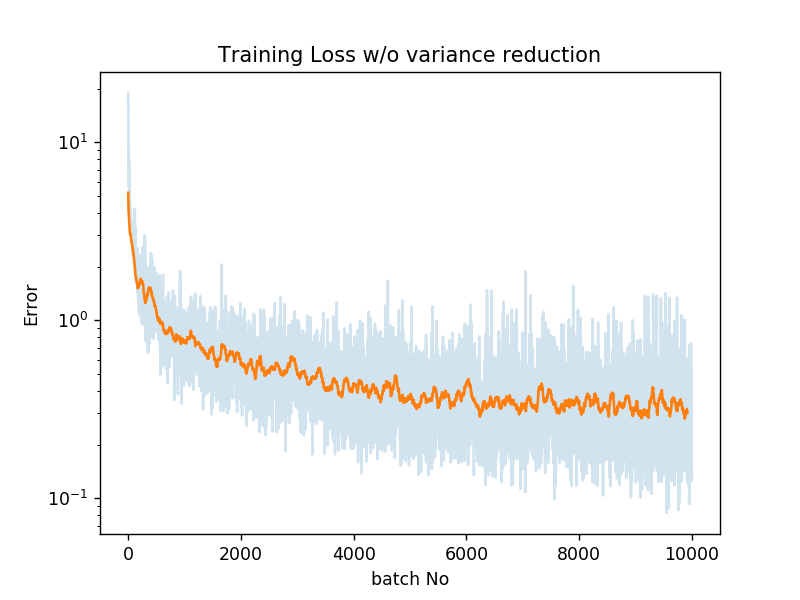

In [48]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss w/o variance reduction')
plt.ylabel('Error')
plt.xlabel('batch No');

tensor(6.7039)
tensor(7.5571)


<IPython.core.display.Javascript object>


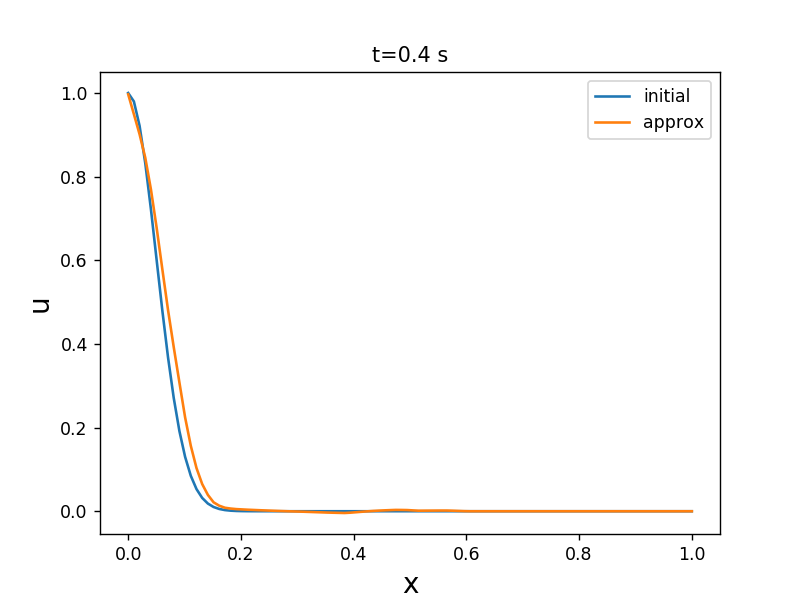

In [49]:
t_val = .4
x = torch.linspace(0, 1, device=device)
t = torch.empty_like(x).fill_(t_val)

y = net(t, x).detach().cpu()
y_initial = dome(x)
print(y_initial.sum())
print(y.sum())
# print('max error', max_error(y_true, y).item())
# print('avg error', avg_error(y_true, y).item())
x = x.cpu().numpy()

plt.figure() 
plt.plot(x, y_initial, label='initial')
plt.plot(x, y.numpy(), label='approx')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t_val} s')
plt.legend();